In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./review_train.csv')
print(df.shape)
df.head()

(50000, 2)


,review,score
0,오늘 오니기리와 이규동 가서 돈가스랑 계란규동 먹었는데 진짜 합리적인 가격에 호강했...,5.0
1,여기는 미스터파파 임실치즈피자 인가 그렇습니다 저도 낚였네요 피자는 가격 저렴한 만...,2.0
2,숯불닭갈비가 그런맛이였다니 처음 먹어본 닭갈비 진짜맛있었어요 춘천또가보고싶네요 정말강추,5.0
3,바하커피샵 전체적인 분위기는 작고 부담이 없다고 할까 하지만 커피맛이 좋은집 카페인...,3.0
4,페북에서 봤는데 가관 장사 망,1.0


In [3]:
def score_evaluate(score):
    if score >= 3.5:
        return 1
    else:
        return 0
df['NP'] = df['score'].apply(score_evaluate) # 긍부정 여부 1,0으로 라벨링

In [4]:
df.head()

,review,score,NP
0,오늘 오니기리와 이규동 가서 돈가스랑 계란규동 먹었는데 진짜 합리적인 가격에 호강했...,5.0,1
1,여기는 미스터파파 임실치즈피자 인가 그렇습니다 저도 낚였네요 피자는 가격 저렴한 만...,2.0,0
2,숯불닭갈비가 그런맛이였다니 처음 먹어본 닭갈비 진짜맛있었어요 춘천또가보고싶네요 정말강추,5.0,1
3,바하커피샵 전체적인 분위기는 작고 부담이 없다고 할까 하지만 커피맛이 좋은집 카페인...,3.0,0
4,페북에서 봤는데 가관 장사 망,1.0,0


In [5]:
len(df[df['NP']==1])/len(df) # 긍정인 반응 / 전체 반응

0.55596

In [6]:
import re

In [7]:
def text_clearing(text): 
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    # 지정한 정규식에 해당하지 않은 것은 길이가 0인 문자열로 변환
    result = hangul.sub('', text)
    return result

In [8]:
df["ko_review"] = df["review"].apply(lambda x : text_clearing(x))

In [9]:
df.drop("review", axis=1, inplace=True)
df

,score,NP,ko_review
0,5.0,1,오늘 오니기리와 이규동 가서 돈가스랑 계란규동 먹었는데 진짜 합리적인 가격에 호강했...
1,2.0,0,여기는 미스터파파 임실치즈피자 인가 그렇습니다 저도 낚였네요 피자는 가격 저렴한 만...
2,5.0,1,숯불닭갈비가 그런맛이였다니 처음 먹어본 닭갈비 진짜맛있었어요 춘천또가보고싶네요 정말강추
3,3.0,0,바하커피샵 전체적인 분위기는 작고 부담이 없다고 할까 하지만 커피맛이 좋은집 카페인...
4,1.0,0,페북에서 봤는데 가관 장사 망
...,...,...,...
49995,5.0,1,하얀짜장 맛있어요 짬뽕도 얼큰하고 든든하게 먹고갑니다
49996,5.0,1,친절하시고 반찬도 많아 좋았어요 직접 산에서 해오신 나물들이라고 설명듣고 먹어보니 ...
49997,1.0,0,옛날에 좋은 추억이 있어 오랫만에 방문했는데 많이 변했더라구요 카페분위기도 어수선하...
49998,4.5,1,저는 되게 맛있게 먹고왔어서요 부산에 가본 횟집들 부산이라는 이름만 있지 막상 가보...


형태소분석

In [10]:
from konlpy.tag import Okt

In [11]:
stopwords = ['도','한','는','은','이','가','와','로','에','들','의','과','자','의','좀','잘','걍','으로','하다','님','다','를','을','자','랑','게','그','에서']

In [12]:
okt = Okt()

In [13]:
okt_review = []
for sentence in df['ko_review']:
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    okt_review.append(stopwords_removed_sentence)

In [19]:
okt_review[0][:10]

['오늘', '오니기리', '이규동', '가다', '돈가스', '계란', '규동', '먹다', '진짜', '합리']

토큰화 & 패딩

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [21]:
# 정수 인코딩 (텍스트를 숫자로 처리할 수 있도록 훈련, 테스트 데이터에 정수 인코딩) 
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(okt_review)

# 단어 집합 생성 -> 높은 숫자일수록 등장 빈도수가 낮음. 
# 등장 빈도수 낮은애들 제거 
word_min = 2 
total_count = len(tokenizer.word_index) 
rare_count = 0 # 등장이 2회 미만

# 빈도수 VALUE 
for key,value in tokenizer.word_counts.items(): 
    if value < word_min: 
        rare_count = rare_count + 1

In [22]:
vocab_size = total_count - rare_count + 2 # OOV와 padding 때문에 +2

In [23]:
vocab_size

16919

In [24]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV') # OOV 토큰 
tokenizer.fit_on_texts(okt_review)

In [25]:
word_dic = tokenizer.word_index
word_dic

{'OOV': 1,
 '먹다': 2,
 '맛있다': 3,
 '맛': 4,
 '좋다': 5,
 '가다': 6,
 '없다': 7,
 '보다': 8,
 '있다': 9,
 '시키다': 10,
 '너무': 11,
 '정말': 12,
 '이다': 13,
 '안': 14,
 '친절하다': 15,
 '요': 16,
 '같다': 17,
 '오다': 18,
 '사장': 19,
 '진짜': 20,
 '고': 21,
 '여기': 22,
 '않다': 23,
 '되다': 24,
 '만': 25,
 '곳': 26,
 '나오다': 27,
 '음식': 28,
 '집': 29,
 '아니다': 30,
 '분': 31,
 '받다': 32,
 '서비스': 33,
 '하고': 34,
 '배달': 35,
 '들다': 36,
 '가격': 37,
 '때': 38,
 '많다': 39,
 '완전': 40,
 '그렇다': 41,
 '사람': 42,
 '서': 43,
 '다른': 44,
 '나': 45,
 '주문': 46,
 '손님': 47,
 '치킨': 48,
 '주다': 49,
 '직원': 50,
 '말': 51,
 '더': 52,
 '못': 53,
 '기분': 54,
 '전화': 55,
 '그냥': 56,
 '고기': 57,
 '또': 58,
 '저': 59,
 '네': 60,
 '나다': 61,
 '것': 62,
 '아깝다': 63,
 '많이': 64,
 '두': 65,
 '추천': 66,
 '괜찮다': 67,
 '인데': 68,
 '까지': 69,
 '알다': 70,
 '시간': 71,
 '자다': 72,
 '해주다': 73,
 '말다': 74,
 '제': 75,
 '돈': 76,
 '깔끔하다': 77,
 '생각': 78,
 '안되다': 79,
 '별': 80,
 '최고': 81,
 '모르다': 82,
 '갈다': 83,
 '장사': 84,
 '이랑': 85,
 '넘다': 86,
 '한번': 87,
 '처음': 88,
 '가보다': 89,
 '맛집': 90,
 '불친절하다': 91,
 '자주': 92,

In [26]:
sequences = tokenizer.texts_to_sequences(okt_review)
print(sequences)

padded = pad_sequences(sequences)
print(padded)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[    0     0     0 ...    41    86     3]
 [    0     0     0 ...   621  1063  1674]
 [    0     0     0 ...    89    12   175]
 ...
 [    0     0     0 ... 11010    10   537]
 [    0     0     0 ...  4627   367  1551]
 [    0     0     0 ...   447   142    20]]


학습과 테스트 세트 분리

In [27]:
x_train = padded
y_train = df['NP']

In [29]:
from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)
print(x_train.shape)
# print(x_test.shape)

(50000, 481)


LSTM

In [30]:
from tensorflow.keras.layers import Embedding,Dense,LSTM
from tensorflow.keras.models import Sequential 
from tensorflow.keras.models import load_model 
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [31]:
model = Sequential() 
model.add(Embedding(vocab_size,64)) 
model.add(LSTM(32)) 
model.add(Dense(1,activation='sigmoid'))

In [32]:
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience=4) 
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='max', verbose=1, save_best_only=True)

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1082816   
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,095,265
Trainable params: 1,095,265
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) 
history = model.fit(x_train, y_train, epochs=100, callbacks=[es,mc], batch_size=200, validation_split=0.2)

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.3575 - acc: 0.8620
Epoch 1: val_loss improved from -inf to 0.27629, saving model to best_model.h5
200/200 [==============================] - 97s 469ms/step - loss: 0.3575 - acc: 0.8620 - val_loss: 0.2763 - val_acc: 0.8971
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.2404 - acc: 0.9141
Epoch 2: val_loss did not improve from 0.27629
200/200 [==============================] - 99s 498ms/step - loss: 0.2404 - acc: 0.9141 - val_loss: 0.2666 - val_acc: 0.9013
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.2195 - acc: 0.9234
Epoch 3: val_loss did not improve from 0.27629
200/200 [==============================] - 90s 449ms/step - loss: 0.2195 - acc: 0.9234 - val_loss: 0.2645 - val_acc: 0.9016
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.2064 - acc: 0.9277
Epoch 4: val_loss did not improve from 0.27629
200/200 [==============================]

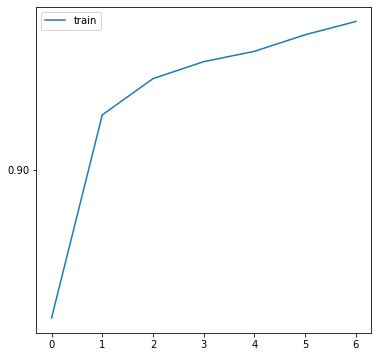

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def show_history(history):
  plt.figure(figsize=(6, 6))
  plt.yticks(np.arange(0, 1, 0.05))
  plt.plot(history.history['acc'], label='train')
  plt.legend()

show_history(history)